<a href="https://colab.research.google.com/github/khavitidala/fuyukai-desu/blob/main/literature/11_midlevel_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
#fastbook.setup_book()

     |████████████████████████████████| 720 kB 6.9 MB/s 
     |████████████████████████████████| 1.2 MB 49.1 MB/s 
     |████████████████████████████████| 189 kB 56.8 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 271 kB/s 


In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Data Munging with fastai's Mid-Level API

## Going Deeper into fastai's Layered API

In [3]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [4]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

### Transforms

In [5]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

In [6]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#181) ['xxbos','xxmaj','this','movie','has','got','to','be','one','of'...]

In [7]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([  2,   8,  20,  25,  67, 202,  15,  41,  42,  14])

In [9]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','xxmaj','this','movie','has','got','to','be','one','of']

In [10]:
tok.decode(nums_dec)

'xxbos xxmaj this movie has got to be one of'

In [11]:
tok((txts[0], txts[1]))

((#181) ['xxbos','xxmaj','this','movie','has','got','to','be','one','of'...],
 (#302) ['xxbos','xxmaj','without','a','doubt','this','is','the','xxup','worse'...])

### Writing Your Own Transform

In [12]:
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

In [13]:
@Transform
def f(x:int): return x+1
f(2),f(2.0)

(3, 2.0)

In [14]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

In [15]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

### Pipeline

In [16]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,   20,   25,   67,  202,   15,   41,   42,   14,    9,   47,   26,   85,    0,   14,    8,  525,    7, 5039])

In [17]:
tfms.decode(t)[:100]

'xxbos xxmaj this movie has got to be one of the all - time xxunk of xxmaj michael xxup j. xxmaj fox '

## TfmdLists and Datasets: Transformed Collections

### TfmdLists

In [18]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

In [19]:
t = tls[0]; t[:20]

TensorText([    2,     8,    20,    30,    61,   208,    15,    43,    44,    14,     9,    45,    24,    77, 13725,    14,     8,   537,     7,  3226])

In [20]:
tls.decode(t)[:100]

"xxbos xxmaj this movie has got to be one of the all - time lows of xxmaj michael xxup j. xxmaj fox '"

In [21]:
tls.show(t)

xxbos xxmaj this movie has got to be one of the all - time lows of xxmaj michael xxup j. xxmaj fox 's generally respectable career . i should have known how awful this movie was when i rented it and found the movie only half viewed and not rewound by the previous renter . xxmaj never a good sign ! xxmaj fox plays a grown up child star who 's now an agent for other show business kids . xxmaj his character is delusional in that he still believes that everyone should love him for being xxmaj mikey . xxmaj his big break comes when he meets xxmaj angie xxmaj vega , a talented child . xxmaj vega is abrasive and not at all likeable . xxmaj in fact , the only likeable character in the whole movie is xxmaj cyndi xxmaj lauper as a xxmaj brooklyn accented receptionist for the agency . xxmaj one of those movies that makes me want to stick a post - it note to the box warning others not to waste their time !


In [22]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

In [23]:
tls.valid[0][:20]

TensorText([    2,     8,    46,    20,   244,    17,   210,   242,  1848,    15,  1069,    21,     8,  3662,     8, 10008,     8, 14817,  1534,    13])

In [24]:
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

In [25]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(0))

In [26]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

### Datasets

In [27]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([    2,     8,    20,    30,    61,   208,    15,    43,    44,    14,     9,    45,    24,    77, 13725,    14,     8,   537,     7,  3226]),
 TensorCategory(0))

In [28]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([    2,     8,    46,    20,   244,    17,   210,   242,  1848,    15,  1069,    21,     8,  3662,     8, 10008,     8, 14817,  1534,    13]),
 TensorCategory(1))

In [29]:
t = dsets.valid[0]
dsets.decode(t)

('xxbos xxmaj at this point it seems almost unnecessary to state that xxmaj jon xxmaj bon xxmaj jovi delivers a firm , strong , seamless performance as xxmaj derek xxmaj bliss . xxmaj his capability as an actor has been previously established by his critical acclaim garnered in other films ( the xxmaj leading xxmaj man , xxmaj no xxmaj looking xxmaj back ) . xxmaj but , in case anyone is still wondering , yes , xxmaj jon xxmaj bon xxmaj jovi can act . xxmaj he can act well and that \'s come to be expected of him . xxmaj it \'s easy to separate xxmaj derek from the guy who belts out hits on xxup vh-1 . \n\n i generally would not watch a horror movie . xxmaj i \'ve come to expect them to focus on sensationalistic gore rather than dialogue and plot . xxmaj what pleased me most about this film was that there really was a viable plot being moved along . xxmaj the gore is not so much as to become the focus of the film and does not have a disturbingly realistic quality of films with higher te

In [30]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

In [34]:
pad_input??

In [35]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

In [36]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

## Applying the Mid-Level Data API: SiamesePair

In [37]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [38]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

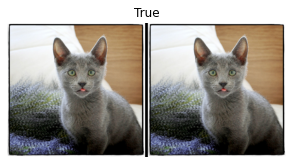

In [39]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

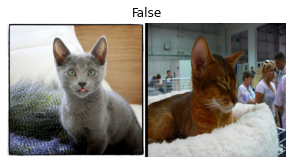

In [40]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

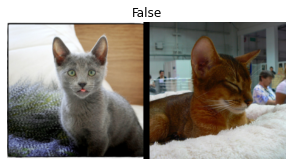

In [41]:
s2 = Resize(224)(s1)
s2.show();

In [42]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [43]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

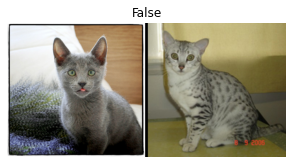

In [44]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

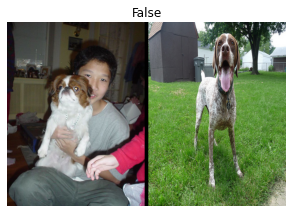

In [45]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [46]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])